In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from pathlib import Path

from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import torch.nn.functional as F
import torchmetrics

import jax
import jax.numpy as jnp
from jax import jit

from pytorch_lightning.strategies import DDPStrategy

from paper_utils import LightningResNet18

import configparser
from paper_utils import HenonMapPoincareDataModule

In [2]:
isBool = lambda x: x.lower() == "true"
converters = {'IntList': lambda x: [int(i.strip()) for i in x.strip(" [](){}").split(',')],
    'FloatList': lambda x: [float(i.strip()) for i in x.strip(" [](){}").split(',')],
    'BoolList': lambda x: [isBool(i.strip()) for i in x.strip(" [](){}").split(',')]}
config = configparser.ConfigParser(converters=converters)

In [3]:
config.read("./configs/model_training/henon_map_study.cfg")
# LOGGING params
# -------------------------------------------------------
log_dir = config.get('LOGGING', 'log_dir')
name = config.get('LOGGING', 'name')
# -------------------------------------------------------
# HARDWARE params  
# -------------------------------------------------------  
num_workers = config.getint('HARDWARE', 'num_workers')
auto_select_gpus = config.getboolean('HARDWARE', 'auto_select_gpus')
num_gpus = config.getint('HARDWARE', 'num_gpus')

if auto_select_gpus==True:
    devices = num_gpus
else:
    devices = config.getIntList("HARDWARE", "devices")
if devices > 1:
    num_workers = 0
    strategy = DDPStrategy(find_unused_parameters=False)
else:
    num_workers = num_workers
    strategy = None
# -------------------------------------------------------
# DATAMODULE params
# -------------------------------------------------------
randomize_flags = config.getBoolList('DATAMODULE', 'randomize')
if "num_train_samples" in config['DATAMODULE']:
    # setting total samples according to 80:20 train/test and train+val/test ratios
    num_sample_list = [int(num / .64) for num in config.getIntList('DATAMODULE', 'num_train_samples')]
    if "num_samples" in config['DATAMODULE']:
        print("WARNING: num_samples and num_train_samples both specified in config. num_samples will be ignored")
else:
    num_sample_list = config.getFloatList('DATAMODULE', 'num_samples')
batch_size = config.getint('DATAMODULE', 'batch_size')
img_widths = config.getIntList('DATAMODULE', 'img_width')
alpha = config.getfloat('DATAMODULE', 'alpha')
min_samples = config.getint('DATAMODULE', 'min_samples', fallback=0)
max_samples = config.getint('DATAMODULE', 'max_samples', fallback=-1)
min_traj_len = config.getint('DATAMODULE', 'min_traj_len')
max_traj_len = config.getint('DATAMODULE', 'max_traj_len')
num_params = config.getint('DATAMODULE', 'num_params')
a_range = config.getFloatList('DATAMODULE', 'a_range')
b_range = config.getFloatList('DATAMODULE', 'b_range')

coords = config.getIntList('DATAMODULE', 'coords', fallback=[0,1])
print(f"{coords=}")
x_range = config.getFloatList('DATAMODULE', 'x_range', fallback=None)
y_range = config.getFloatList('DATAMODULE', 'y_range', fallback=None)

coords=[0, 1]


In [23]:
trainer = pl.Trainer(
    logger=False,
    accelerator='gpu',
    devices=devices,
    num_sanity_val_steps=0,
    deterministic=True,
    auto_select_gpus=auto_select_gpus,
    enable_progress_bar=False
)

assert(len(img_widths) == 1)

np.random.seed(42)
torch.manual_seed(42)

aug_datamodule = HenonMapPoincareDataModule(
                    num_samples=3200,
                    batch_size=32, 
                    a_range=a_range,
                    b_range=b_range,
                    x_range=x_range,
                    y_range=y_range,
                    img_width=img_widths,
                    alpha=alpha,
                    min_samples=min_samples,
                    max_samples=max_samples,
                    min_traj_len=min_traj_len,
                    num_iters=max_traj_len,
                    num_workers=num_workers,
                    verbose=False,
                    randomize=True)

np.random.seed(42)
torch.manual_seed(42)
                    
non_aug_datamodule = HenonMapPoincareDataModule(
                num_samples=3200,
                batch_size=32, 
                a_range=a_range,
                b_range=b_range,
                x_range=x_range,
                y_range=y_range,
                img_width=img_widths,
                alpha=alpha,
                min_samples=min_samples,
                max_samples=max_samples,
                min_traj_len=min_traj_len,
                num_iters=max_traj_len,
                num_workers=num_workers,
                verbose=False,
                randomize=False)

Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
df_list = []
p = Path(log_dir)
for i in p.rglob('*version_0/'):
    print(i.parent.name)
    hparam_dict = yaml.safe_load(open(i / 'hparams.yaml'))
    num_train = hparam_dict['num_train']
    randomized = hparam_dict['randomize']
    print(f"{num_train=}, {randomized=}")
    for child in i.parent.iterdir():
        if child.is_dir():
            for j in child.iterdir():
                if j.is_dir():
                    for model_ckpt in j.iterdir():
                        print(f"{model_ckpt.name=}")
                        model = LightningResNet18.load_from_checkpoint(model_ckpt.resolve())
                        datamodule = aug_datamodule if randomized else non_aug_datamodule
                        test_loss = trainer.test(model=model, dataloaders=datamodule.test_dataloader(), verbose=False)[0]["val_mse"]
                        df_list.append({"loss": test_loss, "num_train": num_train, "Train Augmentation": randomized})
henon_df = pd.DataFrame(df_list)

henon_map_num_samples_1600
num_train=1024, randomized=False
model_ckpt.name='epoch=705-val_mse=4.92e-01_randomized_False.ckpt'


/home/connorsteph/miniconda3/envs/DL_PSI_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=140-val_mse=1.05e+00_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_1600
num_train=1024, randomized=True
model_ckpt.name='epoch=751-val_mse=4.78e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=722-val_mse=5.50e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=768-val_mse=5.88e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_800
num_train=501, randomized=False
model_ckpt.name='epoch=1542-val_mse=6.78e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1163-val_mse=7.18e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1078-val_mse=8.41e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_800
num_train=501, randomized=True
model_ckpt.name='epoch=1554-val_mse=8.26e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1529-val_mse=7.23e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1331-val_mse=6.17e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_400
num_train=256, randomized=False
model_ckpt.name='epoch=2761-val_mse=8.42e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1697-val_mse=8.68e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=2758-val_mse=1.18e+00_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_400
num_train=256, randomized=True
model_ckpt.name='epoch=1782-val_mse=9.19e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=3062-val_mse=9.43e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=2580-val_mse=9.83e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_3200
num_train=2079, randomized=True
model_ckpt.name='epoch=374-val_mse=4.44e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=362-val_mse=4.29e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=339-val_mse=4.03e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_6400
num_train=4096, randomized=True
model_ckpt.name='epoch=188-val_mse=5.22e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=169-val_mse=5.38e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=181-val_mse=4.41e-02_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_200
num_train=125, randomized=False
model_ckpt.name='epoch=3531-val_mse=2.23e+00_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1316-val_mse=2.46e+00_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=3806-val_mse=2.48e+00_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


henon_map_num_samples_200
num_train=125, randomized=True
model_ckpt.name='epoch=4861-val_mse=1.42e-01_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=4112-val_mse=1.64e-01_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=5533-val_mse=1.76e-01_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Text(0, 0.5, 'Test MSE')

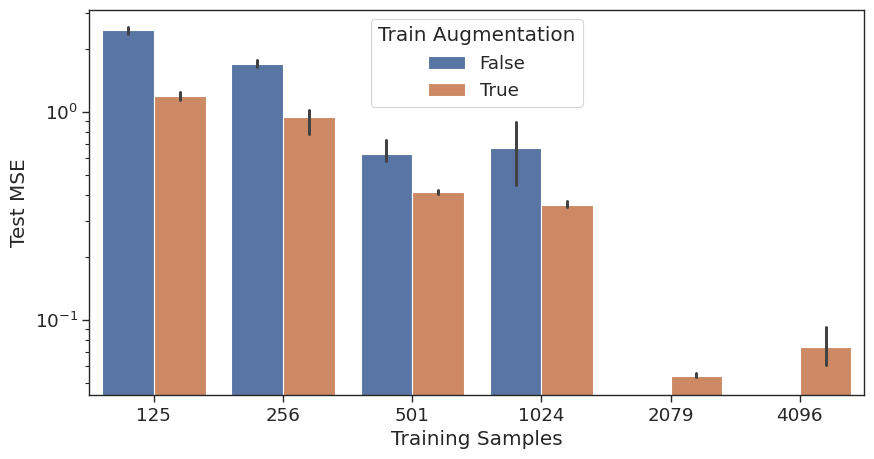

In [26]:
sns.set_theme(context="paper", style="ticks", font_scale=1.5)
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_yscale("log")
# df = pd.read_csv("sample_efficiency_trials.csv")
sns.barplot(data=henon_df, x="num_train", y="loss", hue="Train Augmentation")

ax.set_xlabel("Training Samples")
ax.set_ylabel(f"Test MSE")
# plt.savefig("efficiency_study_test_MSE.pdf", bbox_inches="tight")